# Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import copy
import geopandas as gpd
import plotly.graph_objs as go
import plotly as py
from plotly.offline import init_notebook_mode, iplot
import matplotlib.pyplot as plt
from scipy.stats import probplot
from scipy.stats import ttest_1samp

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import plotly.io as pio
# from IPython.display import Image
# init_notebook_mode()

In [4]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,5)

# Load state names and the corresponding abbreviation

Names of U.S. jurisdictions (states) and their abbreviation are organized into a DataFrame. The abbreviation will be used as geological labels for visualize data in the form of a map.

In [5]:
states = pd.read_excel("./messy_data/states.xlsx")
states.head()

State Abbreviation
0     Alabama           AL
1      Alaska           AK
2     Arizona           AZ
3    Arkansas           AR
4  California           CA

Delete District of Columbia and add an abbraviation FED for Federal because DC is underneath the Federal jurisdiction.

In [6]:
states.drop(states.index[states.Abbreviation == "DC"], inplace=True)
states.columns = ["Jurisdiction", "Jurisdiction Abbreviation"]
states = states.append({"Jurisdiction" : "Federal", "Jurisdiction Abbreviation" : "FED"}, ignore_index=True)
states.tail()

Jurisdiction Jurisdiction Abbreviation
47  West Virginia                        WV
48      Wisconsin                        WI
49        Wyoming                        WY
50    Puerto Rico                        PR
51        Federal                       FED

# Load regions and divisions

The U.S. Census Bureau divides the country into 4 regions -- Northeast, Midwest, South and West. Each region is futhre divided into several divisions.

In [7]:
regions = pd.read_excel("./messy_data/state_region.xlsx")
regions.head()

State     Division     Region
0    Connecticut  New England  Northeast
1          Maine  New England  Northeast
2  Massachusetts  New England  Northeast
3  New Hampshire  New England  Northeast
4   Rhode Island  New England  Northeast

Drop District of Columbia.

In [8]:
regions.drop(regions.index[regions.State == "District of Columbia"], inplace=True)

# Load polygon geodata for different states

In [9]:
usMap = gpd.read_file("./us_states_map.json")
usMap.head()

GEO_ID STATE         NAME LSAD  CENSUSAREA  \
0  0400000US04    04      Arizona       113594.084   
1  0400000US05    05     Arkansas        52035.477   
2  0400000US06    06   California       155779.220   
3  0400000US08    08     Colorado       103641.888   
4  0400000US09    09  Connecticut         4842.355   

                                            geometry  
0  POLYGON ((-112.538593 37.000674, -112.534545 3...  
1  POLYGON ((-94.042964 33.019219, -94.043036 33....  
2  (POLYGON ((-120.248484 33.999329, -120.247393 ...  
3  POLYGON ((-107.317794 41.002957, -107.000606 4...  
4  POLYGON ((-72.397428 42.033302, -72.1988280000...

Drop District of Columbia and Puerto Rico.

In [10]:
usMap = usMap.loc[list(map(lambda x: x not in ["Puerto Rico", "District of Columbia"], usMap.NAME))]

Add state abbreviation and region and division to the geo-dataframe.

In [11]:
usMap = usMap.merge(states, left_on="NAME", right_on = "Jurisdiction", how="left").drop("Jurisdiction", axis=1)
usMap.columns = ["GEO_ID", "STATE", "NAME", "LSAD", "CENSUSAREA", "geometry", "Abbreviation"]

In [12]:
usMap = usMap.merge(regions, left_on="NAME", right_on = "State", how="left").drop("State", axis=1)
usMap.head()

GEO_ID STATE         NAME LSAD  CENSUSAREA  \
0  0400000US04    04      Arizona       113594.084   
1  0400000US05    05     Arkansas        52035.477   
2  0400000US06    06   California       155779.220   
3  0400000US08    08     Colorado       103641.888   
4  0400000US09    09  Connecticut         4842.355   

                                            geometry Abbreviation  \
0  POLYGON ((-112.538593 37.000674, -112.534545 3...           AZ   
1  POLYGON ((-94.042964 33.019219, -94.043036 33....           AR   
2  (POLYGON ((-120.248484 33.999329, -120.247393 ...           CA   
3  POLYGON ((-107.317794 41.002957, -107.000606 4...           CO   
4  POLYGON ((-72.397428 42.033302, -72.1988280000...           CT   

             Division     Region  
0            Mountain       West  
1  West South Central      South  
2             Pacific       West  
3            Mountain       West  
4         New England  Northeast

# Prisoner population data

In [13]:
malePrisonerPopulation = pd.read_excel("./messy_data/Prisoners under the jurisdiction of state or federal correctional authorities 1978-2016.xlsx", sheet_name="Male", header=9, nrows=54).dropna(1, "all").dropna(0)

In [14]:
femalePrisonerPopulation = pd.read_excel("./messy_data/Prisoners under the jurisdiction of state or federal correctional authorities 1978-2016.xlsx", sheet_name="Female", header=9, nrows=54).dropna(1, "all").dropna(0)

In [15]:
totalPrisonerPopulation = pd.read_excel("./messy_data/Prisoners under the jurisdiction of state or federal correctional authorities 1978-2016.xlsx", sheet_name="Total", header=9, nrows=54).dropna(1, "all").dropna(0)
totalPrisonerPopulation.head()

Jurisdiction     1978     1979     1980     1981     1982     1983     1984  \
1      Federal  29803.0  26371.0  24363.0  28133.0  29673.0  31926.0  34263.0   
3      Alabama   5625.0   5464.0   6543.0   7657.0   9233.0   9856.0  10482.0   
4       Alaska    712.0    760.0    822.0   1024.0   1322.0   1631.0   1967.0   
5      Arizona   3456.0   3749.0   4372.0   5223.0   6069.0   6889.0   7845.0   
6     Arkansas   2654.0   3042.0   2911.0   3328.0   3922.0   4246.0   4482.0   

      1985     1986  ...    2007    2008    2009    2010    2011    2012  \
1  40223.0  44408.0  ...  199618  201280  208118  209771  216362  217815   
3  11015.0  11710.0  ...   29412   30508   31874   31764   32270   32431   
4   2329.0   2460.0  ...    5167    5014    5285    5391    5597    5633   
5   8531.0   9434.0  ...   37746   39502   40544   40209   40020   40080   
6   4611.0   4701.0  ...   14314   14716   15208   16204   16108   14654   

     2013    2014    2015    2016  
1  215866  210567  196455  189192  
3   32381   31771   30810   28883  
4    5081    5794    5338    4434  
5   41177   42259   42719   42320  
6   17235   17874   17707   17537  

[5 rows x 40 columns]

## Clean and melt the population tables

In [16]:
def cleanAndMeltPopulationTable(table, states):
    
    # add DC data to Federal, and delete it
    table.loc[table.Jurisdiction == "Federal"].iloc[:, 1:] = table.loc[table.Jurisdiction == "Federal"].iloc[:, 1:] + table.loc[table.Jurisdiction == "District of Columbia"].iloc[:, 1:].replace("--", 0)
    table.drop(table.index[table.Jurisdiction == "District of Columbia"], inplace=True)

    table = table.melt(id_vars = "Jurisdiction", var_name = "Year", value_name = "Population")
    table.Year = table.Year.astype(int)
    table.Population = table.Population.astype(int)
    
    table = states.merge(table, on="Jurisdiction")
    
    return table

Originally, District of Columbia was treated as an independent jurisdiction in Bureau of Justice Statistics's survey. However, as of 2001, it is being considered as part of the federal jurisdiction. This created some missing values for the District of Columbia data and the federal data starting in 2001. To correct for the inconsistency, the District of Comubia data prior to 2001 is added into the federal prisoner population during data cleaning.

In [17]:
meltedMalePrisonerPopulation = cleanAndMeltPopulationTable(malePrisonerPopulation, states)
meltedFemalePrisonerPopulation = cleanAndMeltPopulationTable(femalePrisonerPopulation, states)
meltedTotalPrisonerPopulation = cleanAndMeltPopulationTable(totalPrisonerPopulation, states)

meltedTotalPrisonerPopulation.head()

Jurisdiction Jurisdiction Abbreviation  Year  Population
0      Alabama                        AL  1978        5625
1      Alabama                        AL  1979        5464
2      Alabama                        AL  1980        6543
3      Alabama                        AL  1981        7657
4      Alabama                        AL  1982        9233

## Aggregate and sum the state prisoner population for regions and divisions

In [18]:
def aggregateRegionalPopulationSum(table, regions):
    
    table = regions.merge(table, left_on="State", right_on="Jurisdiction", how="right")
    temp_index = table["Jurisdiction"] == "Federal"
    table.loc[temp_index, "Region"] = "Federal"
    table.loc[temp_index, "Division"] = "Federal"
    
    regionSum = table.groupby(["Year", "Region"]).Population.sum()
    divisionSum = table.groupby(["Year", "Region", "Division"]).Population.sum()
    
    return regionSum, divisionSum

In [19]:
malePrisonerPopulationRegionSum, malePrisonerPopulationDivisionSum = aggregateRegionalPopulationSum(meltedMalePrisonerPopulation, regions)
femalePrisonerPopulationRegionSum, femalePrisonerPopulationDivisionSum = aggregateRegionalPopulationSum(meltedFemalePrisonerPopulation, regions)
totalPrisonerPopulationRegionSum, totalPrisonerPopulationDivisionSum = aggregateRegionalPopulationSum(meltedTotalPrisonerPopulation, regions)

## Plot maps illustrating the prisoner population in different states

In [20]:
def plotAnnualStatePopulation(table, gender, years_chosen):
    
    table = table[table.Jurisdiction != "Federal"]

    cmax = table.Population.max()
    cmin = table.Population.min()
    
    years = table.Year.unique()

    heatMapData = [{"type" : "choropleth",  "locations" : table.loc[table.Year == year, "Jurisdiction Abbreviation"], "locationmode" : "USA-states", "colorscale" : "Viridis", "zmin" : cmin, "zmax" : cmax, "z" : table.Population[table.Year == year].astype(float)} for year in years]
    mapLayout = [{"geo" : {"scope" : 'usa'}, "title" : gender + " Prisoner Population by State, " + str(year)} for year in years]
    
    for i, data in enumerate(heatMapData):
        if years[i] in years_chosen:
            usHeatMap = go.Figure(data=[data], layout=mapLayout[i])
#             iplot(usHeatMap)
#             Image(pio.to_image(usHeatMap, format='png'))
            usHeatMap.show(renderer="svg")

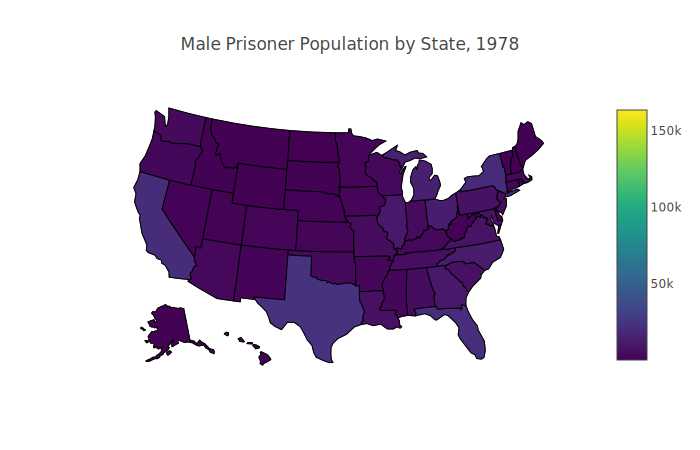

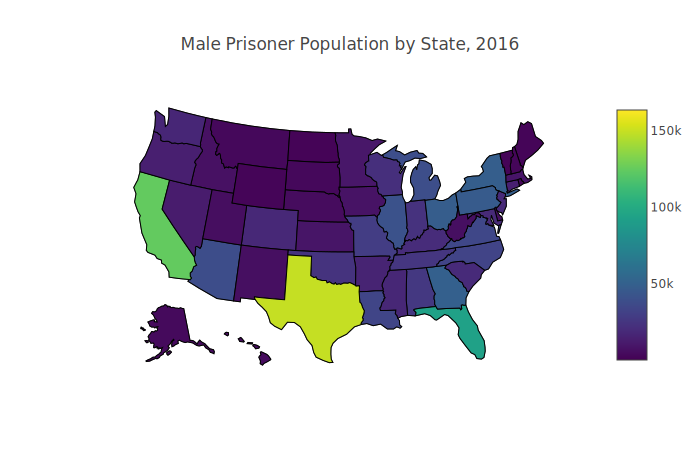

In [21]:
plotAnnualStatePopulation(meltedMalePrisonerPopulation, "Male", [1978, 2016])

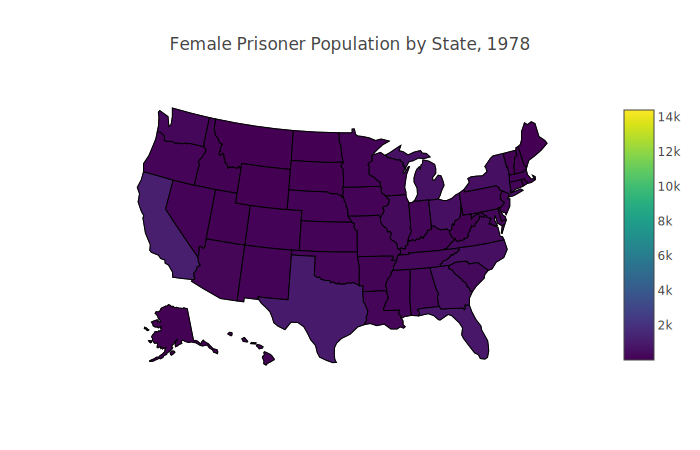

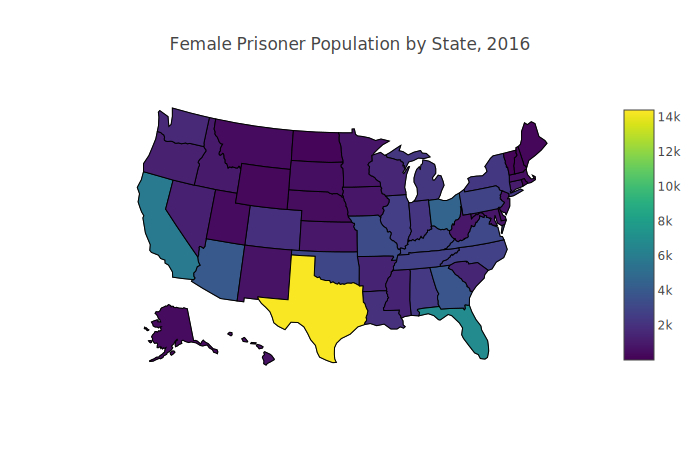

In [22]:
plotAnnualStatePopulation(meltedFemalePrisonerPopulation, "Female", [1978, 2016])

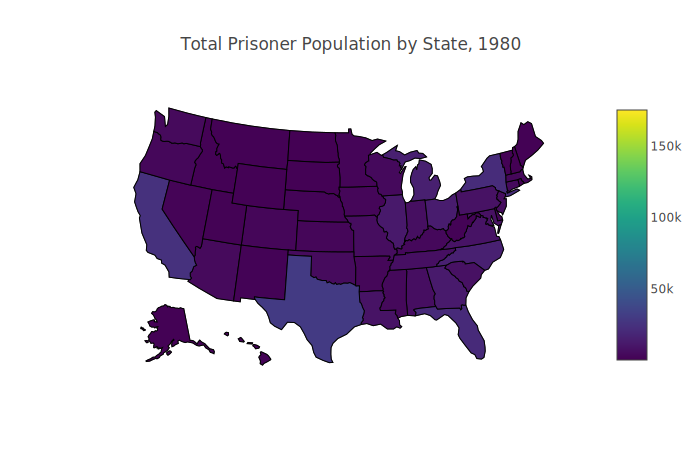

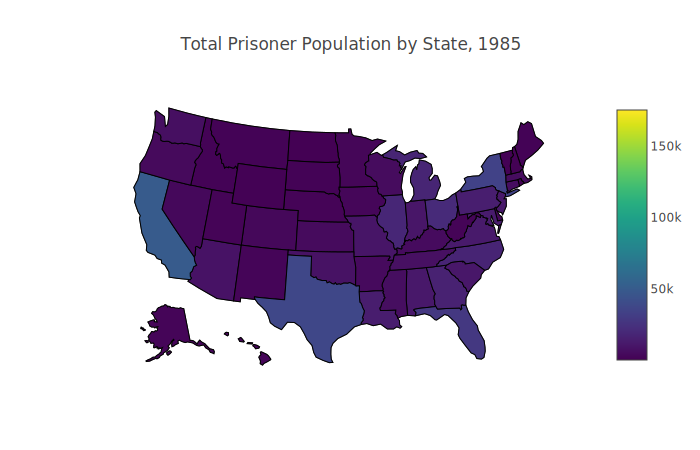

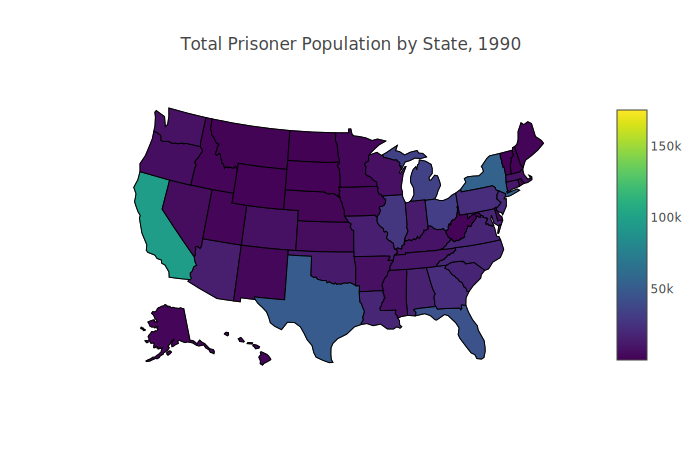

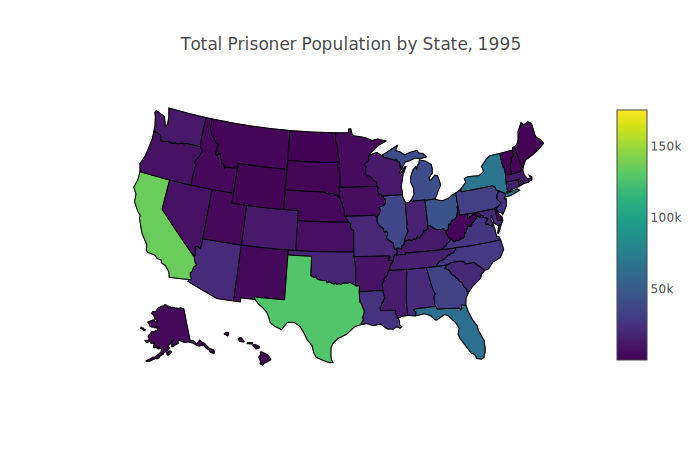

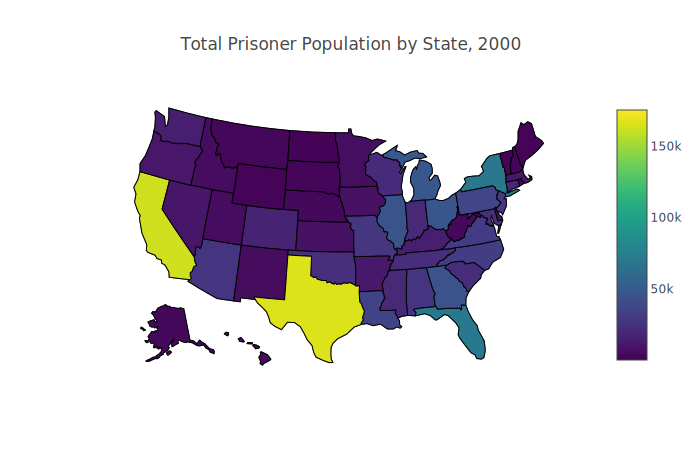

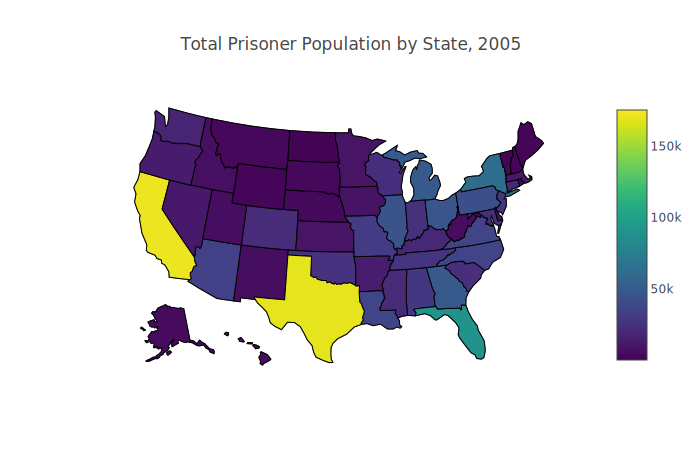

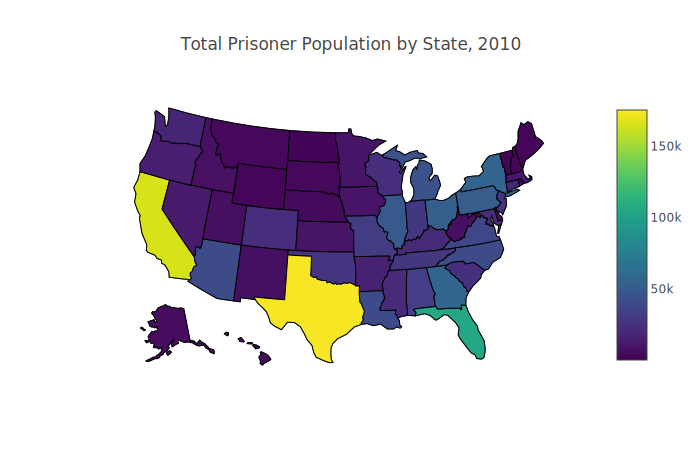

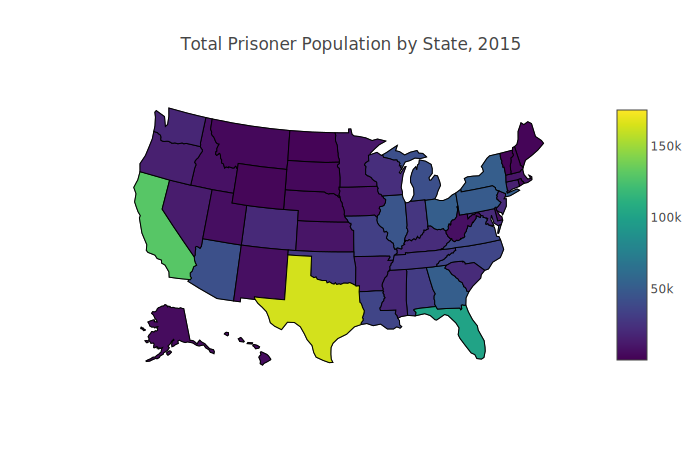

In [23]:
plotAnnualStatePopulation(meltedTotalPrisonerPopulation, "Total", [1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015])

The prisoner population in most jurisdictions has been increasing in both the male and female systems considerably since 1987. The elevation is especially prominent in California, Texas and Florida.

## Plot maps illustrating priosoner population in different regions and divisions

In [24]:
def plotGeoPandasUSMap(usMap, title=None, dataColumn=None, dataLimit=(None, None)):
    
    fig, mapAx = plt.subplots(1, 1)
    
    mapLimitW, mapLimitE, mapLimitS, mapLimitN = -185, -65, 15, 75
    mapAx.axis((mapLimitW, mapLimitE, mapLimitS, mapLimitN))
    mapAx.axis('off')
    mapAx.set_aspect('equal', 'box')
    mapAx.set_title(title)
    
    usMap.plot(column=dataColumn, edgecolor="k", ax=mapAx, legend=True, vmin=dataLimit[0], vmax=dataLimit[1]) #, figsize=(20,20))
    
#     sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=dataLimit[0], vmax=dataLimit[1]))
#     sm._A = []
#     cbar = mapAx.colorbar(sm)

In [25]:
def plotRegionalPopulation(table, usMap, gender, years_chosen):
    
    regionType = table.index.names[1]

    tableWOFederal = table[table.index.get_level_values(1) != "Federal"]

    years = table.index.get_level_values(0).unique()
    dividedTableWOFederal = [tableWOFederal[year] for year in years]

    usRegionMap = usMap[[regionType, "geometry"]].dissolve(regionType)

    colorlimit = (tableWOFederal.min(), tableWOFederal.max())
    for i, oneYearTable in enumerate(dividedTableWOFederal):
        year = years[i]
        
        if year in years_chosen:

            oneYearTable = usRegionMap.join(oneYearTable)

            figtitle = gender + " Prisoner Population by " + regionType + ", " + str(year)
            plotGeoPandasUSMap(oneYearTable, figtitle, "Population", colorlimit)


    figtitle = gender + " Prisoner Population by " + regionType
    ax = table.unstack().plot(title = figtitle)
    ax.set_ylim(bottom=0)
    ax.tick_params(axis = "y", length=0)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=len(table.index.get_level_values(1).unique()))

### Plot regions

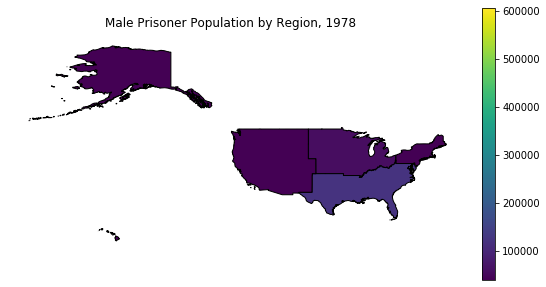

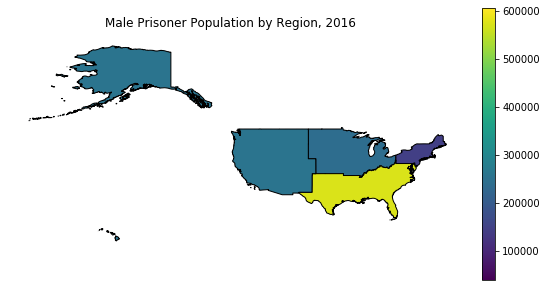

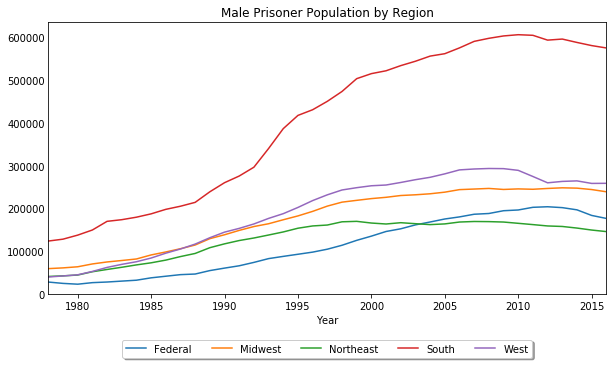

In [26]:
plotRegionalPopulation(malePrisonerPopulationRegionSum, usMap, "Male", [1978, 2016])

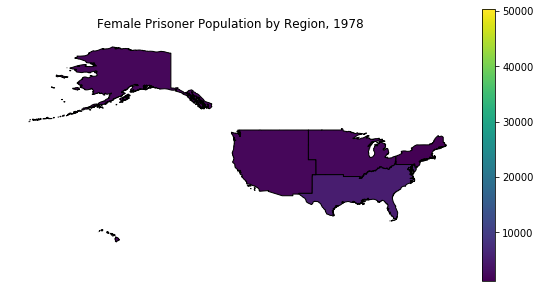

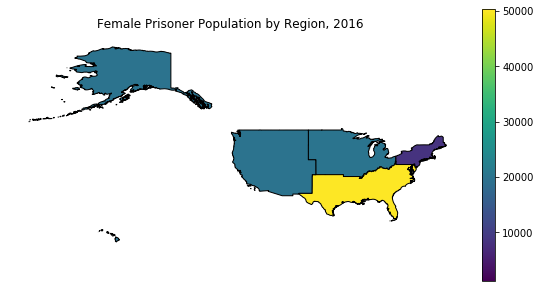

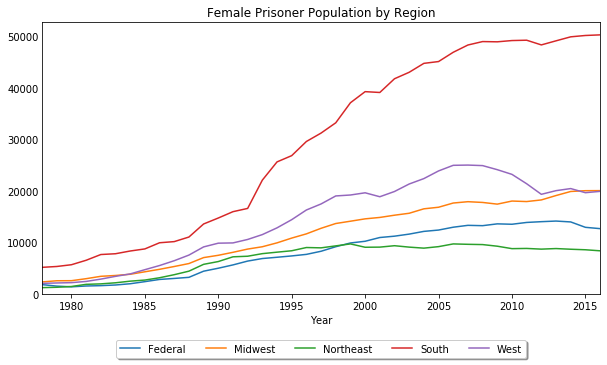

In [27]:
plotRegionalPopulation(femalePrisonerPopulationRegionSum, usMap, "Female", [1978, 2016])

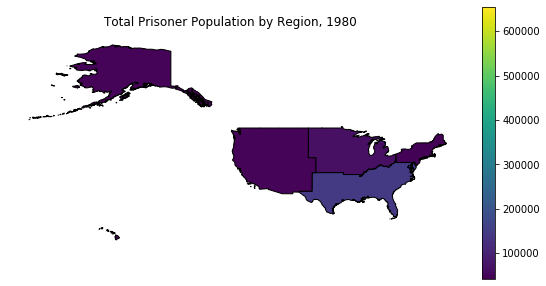

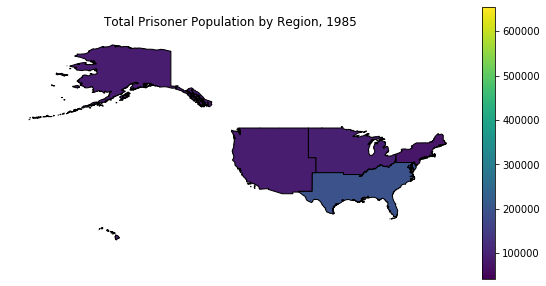

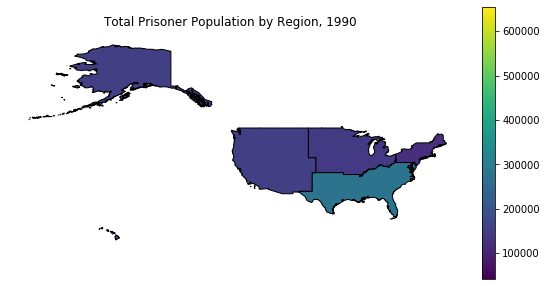

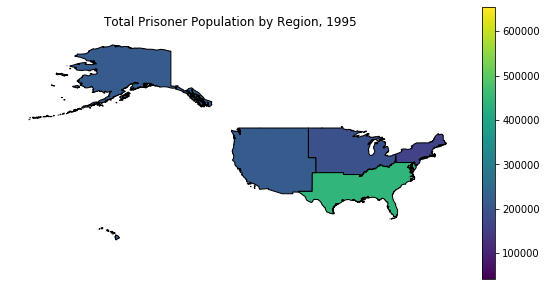

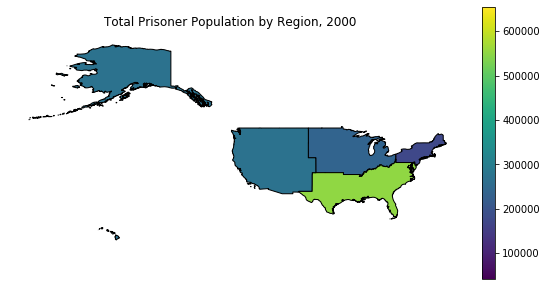

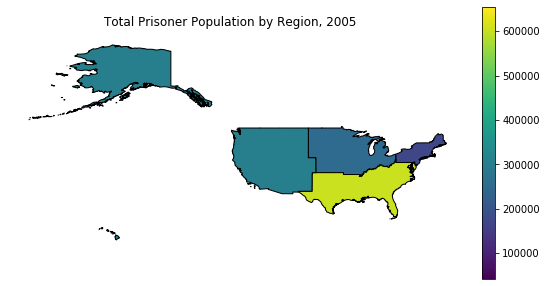

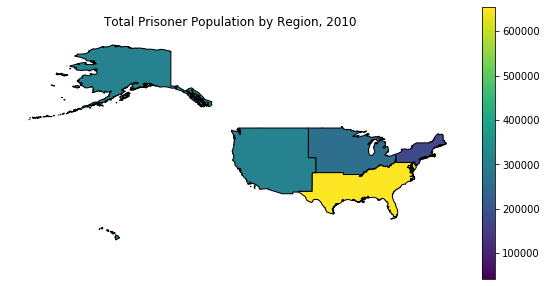

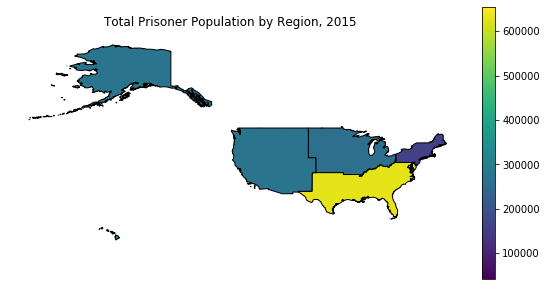

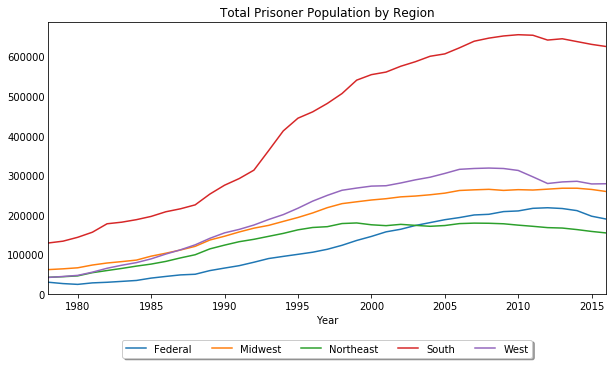

In [28]:
plotRegionalPopulation(totalPrisonerPopulationRegionSum, usMap, "Total", [1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015])

### Plot Divisions

In [29]:
def dropRegionIndex(table):
    table = copy.deepcopy(table)
    
    table.index = table.index.droplevel(1)
    return table


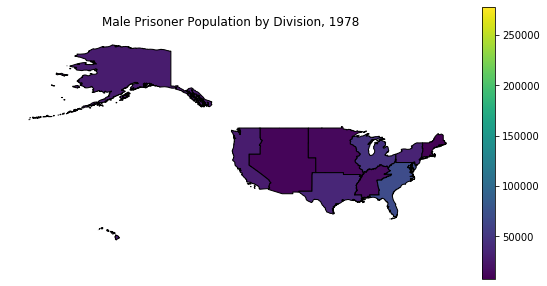

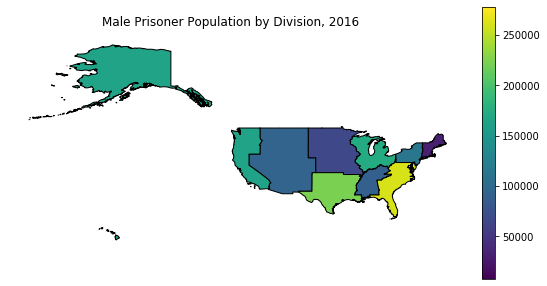

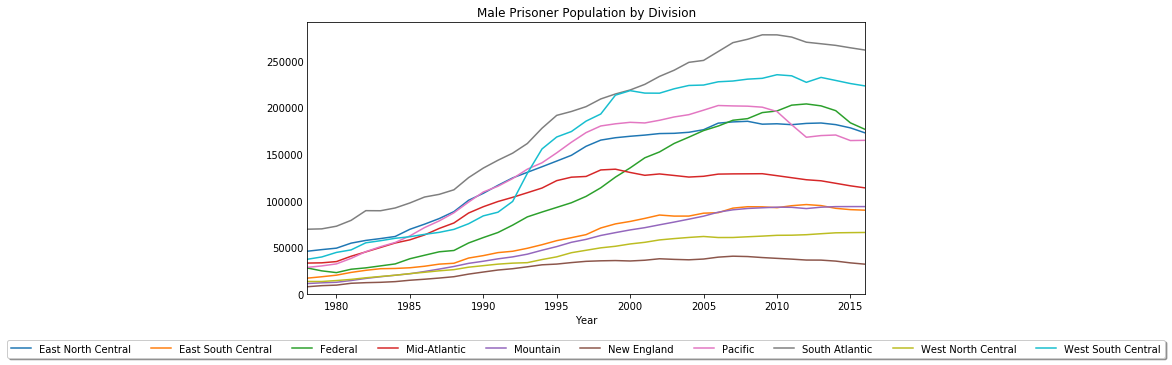

In [30]:
plotRegionalPopulation(dropRegionIndex(malePrisonerPopulationDivisionSum), usMap, "Male", [1978, 2016])

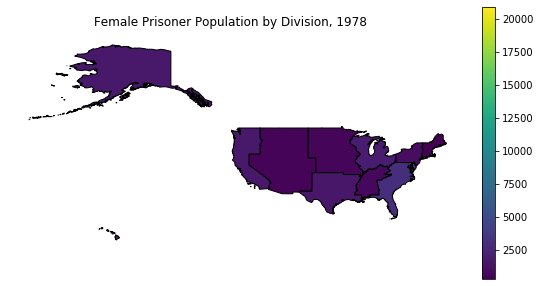

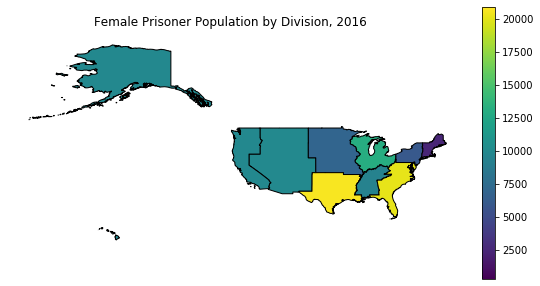

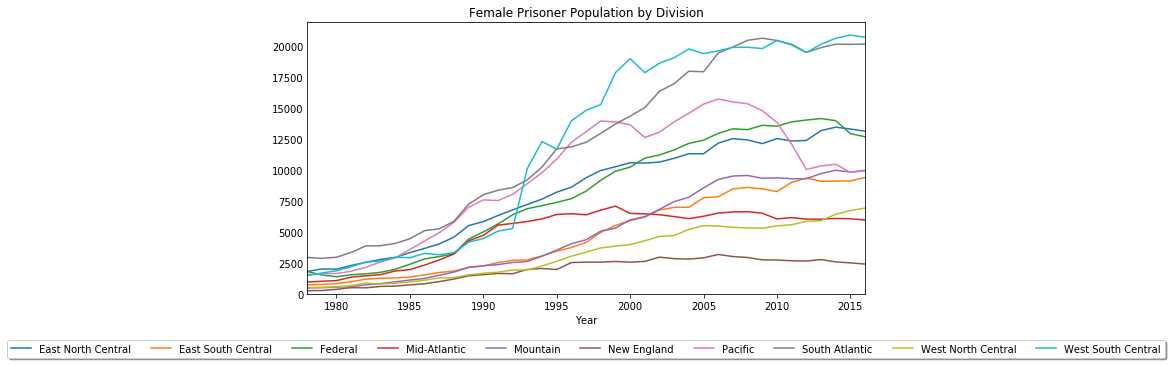

In [31]:
plotRegionalPopulation(dropRegionIndex(femalePrisonerPopulationDivisionSum), usMap, "Female", [1978, 2016])

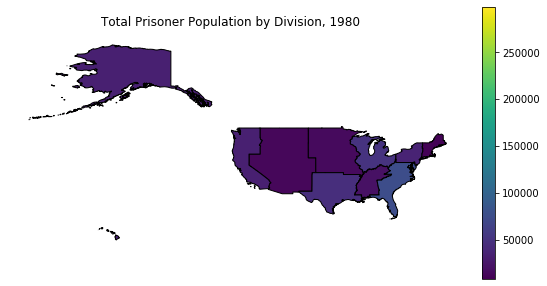

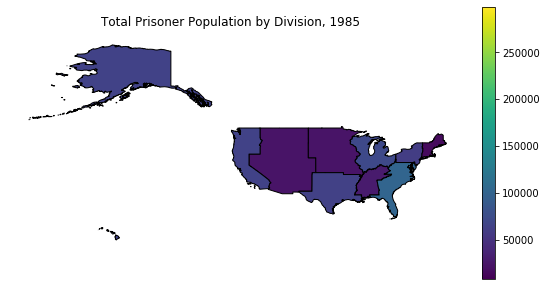

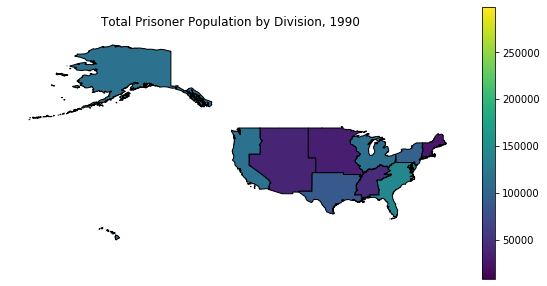

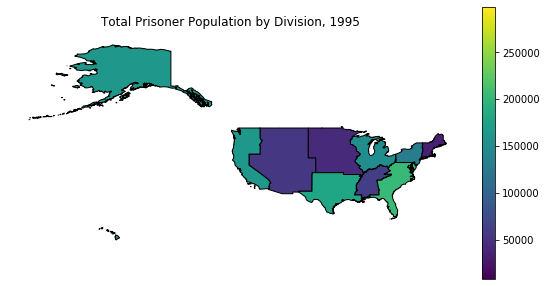

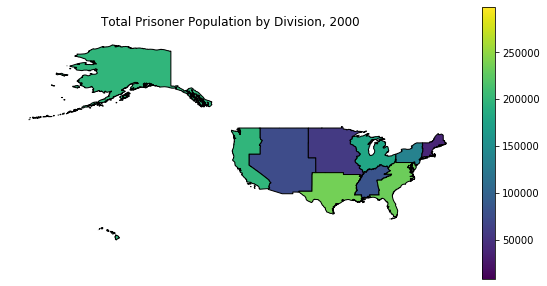

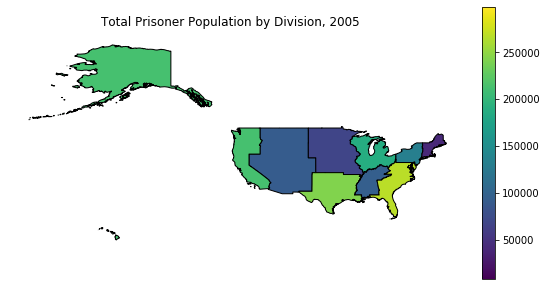

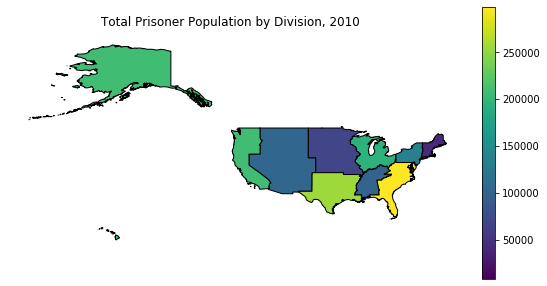

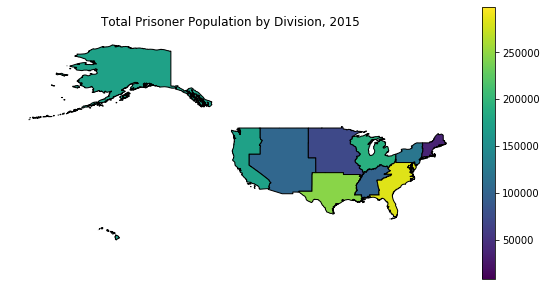

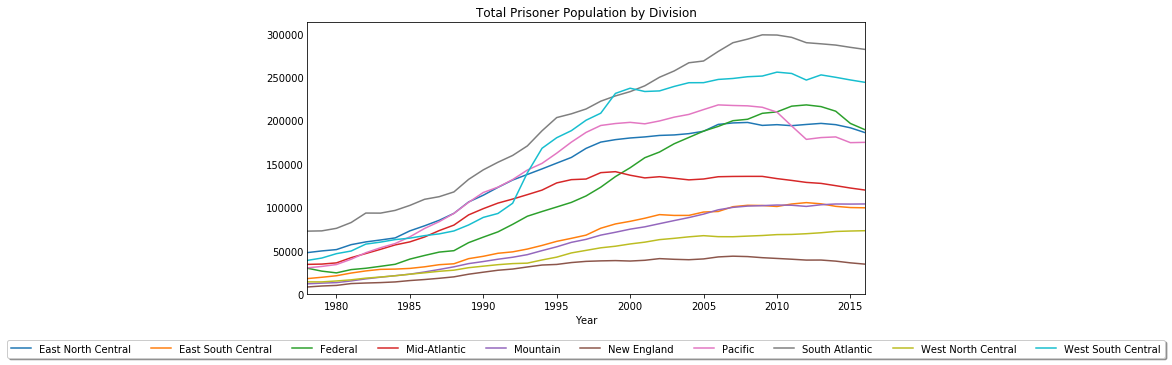

In [32]:
plotRegionalPopulation(dropRegionIndex(totalPrisonerPopulationDivisionSum), usMap, "Total", [1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015])

The prisoner population has been growing the fastest in the South. It is mostly driven by the rapid increase in South Atlantic and South West Central due to growth in Florida and Texas, respectively.

# Facility occupancy data

In [33]:
custodyPopulation_11_16 = pd.read_excel("./messy_data/Prison occupation rate.xlsx", "Custody Population", na_values="/")

occupancyLowRate_11_16 = pd.read_excel("./messy_data/Prison occupation rate.xlsx", "Highest Capacity", na_values="/")
occupancyHighRate_11_16 = pd.read_excel("./messy_data/Prison occupation rate.xlsx", "Lowest Capacity", na_values="/")

In [34]:
custodyPopulation_11_16.head()

Jurisdiction    2011    2012      2013    2014    2015    2016
0      Federal  176228  176658  174242.0  169840  160946  154339
1      Alabama   26268   26230   26271.0   25664   24814   23397
2       Alaska    3708    4575    5054.0    5188    5247    4378
3      Arizona   33492   33578   34626.0   35181   35733   42248
4     Arkansas   14090   14043   14295.0   15250   15784   15833

Two occupancy rates were reported -- low estimation and high estimation

In [35]:
occupancyHighRate_11_16.head()

Jurisdiction   2011   2012        2013        2014   2015   2016
0      Federal  138.0  137.3  133.103654  127.958050  119.7  114.0
1      Alabama  196.0  195.7  197.259348  192.701607  186.3  175.7
2       Alaska  121.0  149.6         NaN   96.935725   98.0   90.5
3      Arizona   90.0   91.5   94.397645   93.365357   96.0  108.6
4     Arkansas  105.0  101.3  102.952827   98.839847  102.6  101.3

In [36]:
occupancyHighRate_11_16.head()

Jurisdiction   2011   2012        2013        2014   2015   2016
0      Federal  138.0  137.3  133.103654  127.958050  119.7  114.0
1      Alabama  196.0  195.7  197.259348  192.701607  186.3  175.7
2       Alaska  121.0  149.6         NaN   96.935725   98.0   90.5
3      Arizona   90.0   91.5   94.397645   93.365357   96.0  108.6
4     Arkansas  105.0  101.3  102.952827   98.839847  102.6  101.3

## Clean and melt tables

In [37]:
def cleanAndMeltCustodyOccupancyTable(table, states, tableType):
    
    table = table.melt(id_vars = "Jurisdiction", var_name = "Year", value_name = tableType)
    if tableType == "Occupancy":
        table.Occupancy = table.Occupancy / 100
    
    table.Year = table.Year.astype(int)
    table = states.merge(table, on="Jurisdiction")
    
    return table

In [38]:
meltedCustodyPopulation_11_16 = cleanAndMeltCustodyOccupancyTable(custodyPopulation_11_16, states, "Population")
meltedOccupancyLowRate_11_16 = cleanAndMeltCustodyOccupancyTable(occupancyLowRate_11_16, states, "Occupancy")
meltedOccupancyHighRate_11_16 = cleanAndMeltCustodyOccupancyTable(occupancyHighRate_11_16, states, "Occupancy")

In [39]:
meltedCustodyPopulation_11_16.head()

Jurisdiction Jurisdiction Abbreviation  Year  Population
0      Alabama                        AL  2011     26268.0
1      Alabama                        AL  2012     26230.0
2      Alabama                        AL  2013     26271.0
3      Alabama                        AL  2014     25664.0
4      Alabama                        AL  2015     24814.0

In [40]:
def plotAnnualStateOccupancy(table, low_or_high, years_chosen):
    
    table = table[table.Occupancy != "Federal"]

    cmax = table.Occupancy.max()
    cmin = table.Occupancy.min()
    
    years = table.Year.unique()

    heatMapData = [{"type" : "choropleth",  "locations" : table.loc[table.Year == year, "Jurisdiction Abbreviation"], "locationmode" : "USA-states", "colorscale" : "Viridis", "zmin" : cmin, "zmax" : cmax, "z" : table.Occupancy[table.Year == year].astype(float)} for year in years]
    mapLayout = [{"geo" : {"scope" : 'usa'}, "title" : "Prison Occupancy (" + low_or_high + " Estimation) by State, " + str(year)} for year in years]
    
    for i, data in enumerate(heatMapData):
        if years[i] in years_chosen:
            usHeatMap = go.Figure(data=[data], layout=mapLayout[i])
#             iplot(usHeatMap)
#             Image(pio.to_image(usHeatMap, format='png'))
            usHeatMap.show(renderer="svg")

## Plot occupancy maps for states

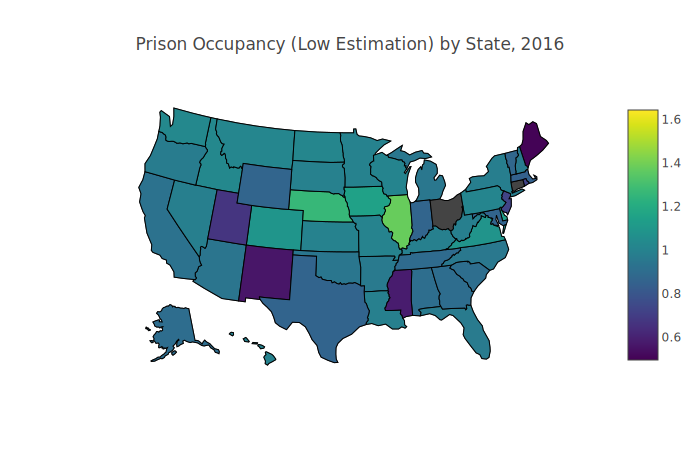

In [41]:
plotAnnualStateOccupancy(meltedOccupancyLowRate_11_16, "Low", [2011, 2016])

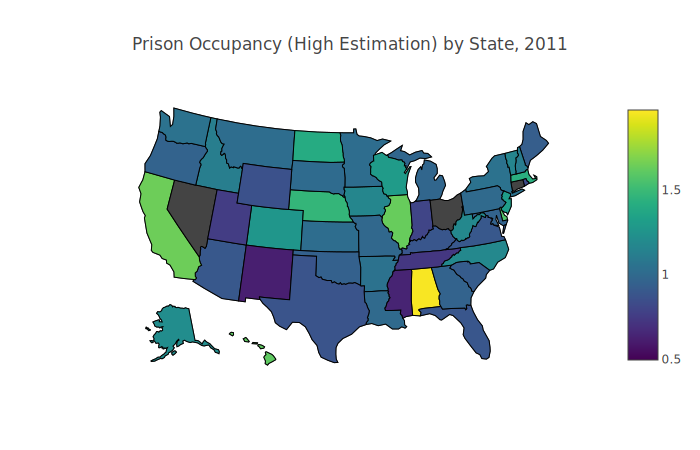

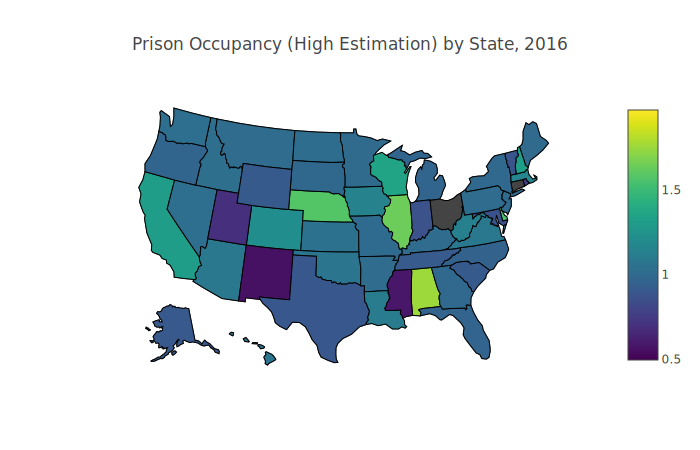

In [42]:
plotAnnualStateOccupancy(meltedOccupancyHighRate_11_16, "High", [2011, 2016])

The data suggest during the second decade of the 21st century, the occupancy rate of U.S. prisons are reducing. This is especially true for some states such as California. However, for many states, their prisons are still operating over 100% of its capacity.

## Calculate regional and divisional occupancy 

In [43]:
def aggregateRegionalOccupancy(table, populationTable, regions):
    
    table = regions.merge(table.dropna(), left_on="State", right_on="Jurisdiction", how="right")
    table = table.merge(populationTable[["Jurisdiction", "Year", "Population"]].dropna(), on=["Jurisdiction", "Year"], how="left")

    temp_index = table["Jurisdiction"] == "Federal"
    table.loc[temp_index, "Region"] = "Federal"
    table.loc[temp_index, "Division"] = "Federal"
    table["Capacity"] = table.Population / table.Occupancy
    
    regionCapacity = table.groupby(["Year", "Region"]).Capacity.sum()
    divisionCapacity = table.groupby(["Year", "Region", "Division"]).Capacity.sum()
    
    regionPopulation = table.groupby(["Year", "Region"]).Population.sum()
    divisionPopulation = table.groupby(["Year", "Region", "Division"]).Population.sum()
    
    regionOccupancy = (regionPopulation / regionCapacity).rename("Occupancy")
    divisionOccupancy = (divisionPopulation / divisionCapacity).rename("Occupancy")
    
    return regionOccupancy, divisionOccupancy

In [44]:
regionLowOccupancy, divisionLowOccupancy = aggregateRegionalOccupancy(meltedOccupancyLowRate_11_16, meltedCustodyPopulation_11_16, regions)
regionHighOccupancy, divisionHighOccupancy = aggregateRegionalOccupancy(meltedOccupancyHighRate_11_16, meltedCustodyPopulation_11_16, regions)

## Plot maps for regions and divisions

In [45]:
def plotRegionalOccupancy(table, usMap, low_or_high, years_chosen):
    
    regionType = table.index.names[1]

    tableWOFederal = table[table.index.get_level_values(1) != "Federal"]

    years = table.index.get_level_values(0).unique()
    dividedTableWOFederal = [tableWOFederal[year] for year in years]

    usRegionMap = usMap[[regionType, "geometry"]].dissolve(regionType)

    colorlimit = (tableWOFederal.min(), tableWOFederal.max())
    for i, oneYearTable in enumerate(dividedTableWOFederal):
        year = years[i]
        
        if year in years_chosen:
        
            oneYearTable = usRegionMap.join(oneYearTable)

            figtitle = "Prison Occupancy (" + low_or_high + " Estimate) by " + regionType + ", " + str(year)
            plotGeoPandasUSMap(oneYearTable, figtitle, "Occupancy", colorlimit)


    figtitle = "Prison Occupancy (" + low_or_high + " Estimate) by " + regionType
    ax = table.unstack().plot(title = figtitle)
    ax.tick_params(axis = "y", length=0)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=len(table.index.get_level_values(1).unique()))

### Plot regions

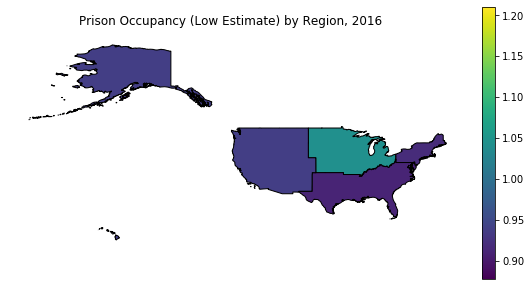

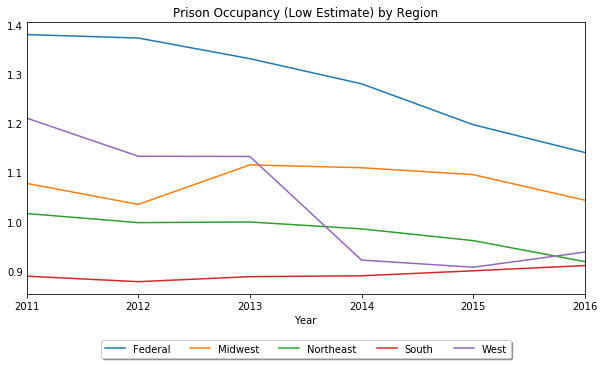

In [46]:
plotRegionalOccupancy(regionLowOccupancy, usMap, "Low", [2011, 2016])

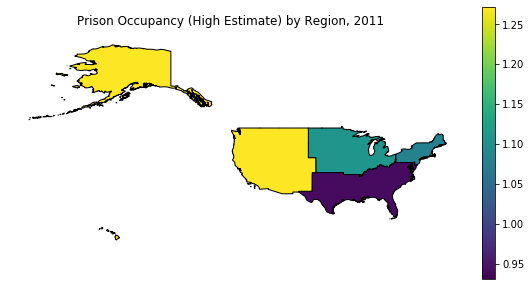

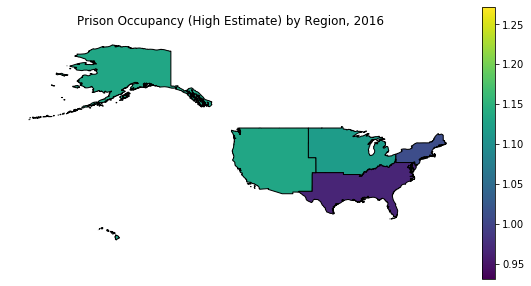

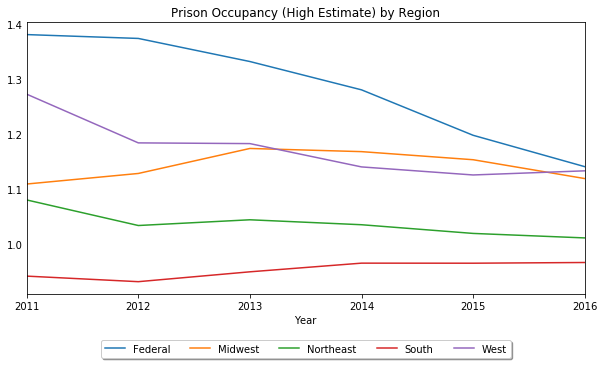

In [47]:
plotRegionalOccupancy(regionHighOccupancy, usMap, "High", [2011, 2016])

Currently, the prisons in the Northeast and the South are running below their full capacity. Although the Federal correction facilities are still over-crowded, its occupancy rate has dropped significantly during the second decade of this century.

### Plot divisions

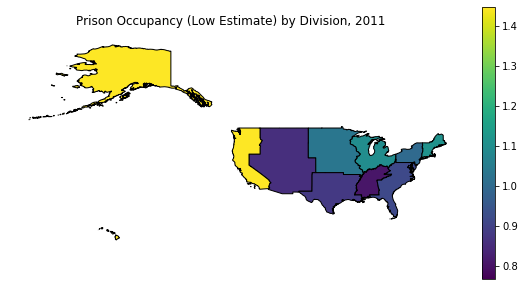

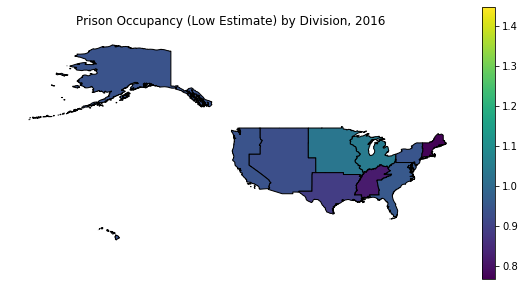

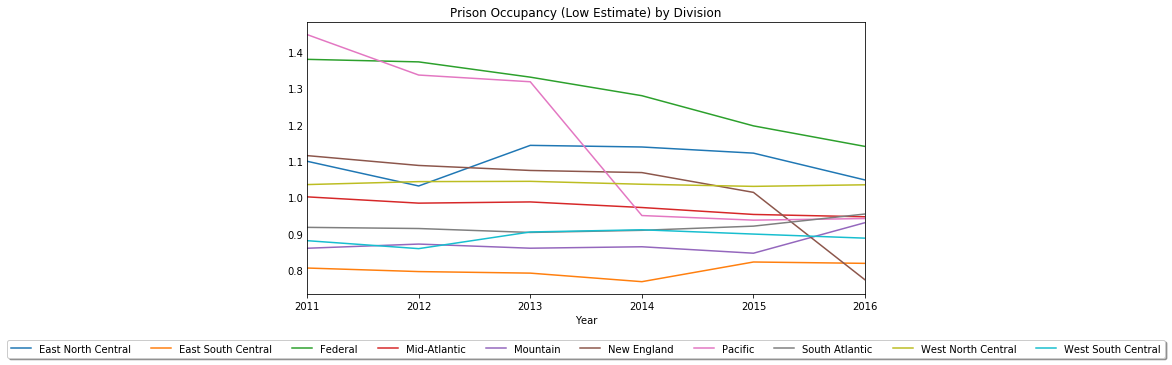

In [48]:
plotRegionalOccupancy(dropRegionIndex(divisionLowOccupancy), usMap, "Low", [2011, 2016])

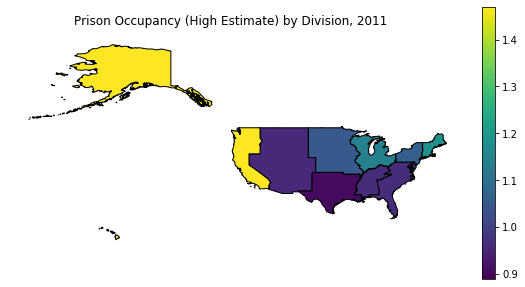

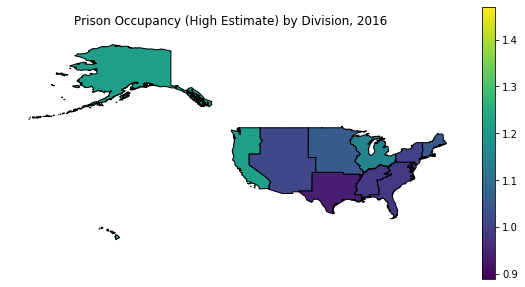

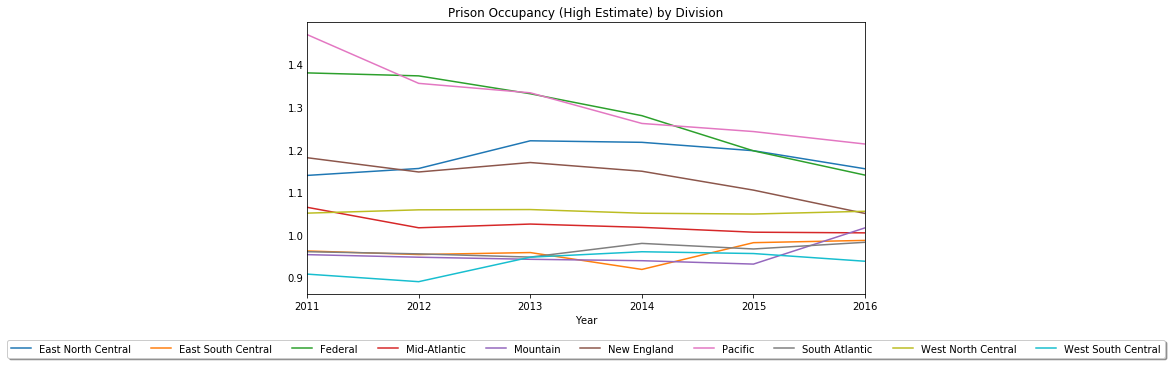

In [49]:
plotRegionalOccupancy(dropRegionIndex(divisionHighOccupancy), usMap, "High", [2011, 2016])

The prison system in the Mountain, Mid-Atlantic, Pacific, East South Central, South Atlantic and West South Central divisions is not over-filled at the moment. Although is prison occupancy rate is very high in the Pacific, it is decreasing rapidly.

# Admission and release data

## Load admission

In [50]:
totalAdmission = pd.read_excel("./messy_data/admissions.xlsx", sheet_name="Total").dropna().replace("/", np.nan)
totalAdmission.head()

Jurisdiction     1978     1979     1980     1981     1982     1983     1984  \
1      Federal  14724.0  14120.0  12598.0  12830.0  14818.0  16745.0  16013.0   
3      Alabama   2572.0   2597.0   3766.0   4025.0   4425.0   4605.0   4701.0   
4       Alaska    258.0    311.0    459.0    461.0    541.0    711.0    727.0   
5      Arizona   1620.0   1641.0   2082.0   2759.0   2910.0   3288.0   3386.0   
6     Arkansas   1958.0   2189.0   2311.0   2419.0   2323.0   2173.0   2179.0   

      1985     1986  ...   2007   2008   2009   2010   2011   2012   2013  \
1  17916.0  18501.0  ...  53618  53662  56153  54121  60634  55938  53664   
3   4370.0   3962.0  ...  10708  11037  13093  11881  11387  11203  11265   
4    875.0   1097.0  ...    NaN    NaN    NaN   2650   3789   3906   3906   
5   3989.0   4515.0  ...  14046  14867  14526  13249  13030  12970  13538   
6   2301.0   2280.0  ...   6651   7017   7383   7603   7059   5782   8987   

    2014   2015   2016  
1  50865  46912  44682  
3  10912  10451  10749  
4   3846   4271   1804  
5  14439  14670  13663  
6   9435   9351   9911  

[5 rows x 40 columns]

In [51]:
maleAdmission = pd.read_excel("./messy_data/admissions.xlsx", sheet_name="Male").dropna().replace("/", np.nan)
femaleAdmission = pd.read_excel("./messy_data/admissions.xlsx", sheet_name="Female").dropna().replace("/", np.nan)

### Clean and melt tables

In [52]:
def cleanAndMeltCountTable(table, states):
    
    # add DC data to Federal, and delete it
    table.loc[table.Jurisdiction == "Federal"].iloc[:, 1:] = table.loc[table.Jurisdiction == "Federal"].iloc[:, 1:] + table.loc[table.Jurisdiction == "District of Columbia"].iloc[:, 1:].replace("--", 0)
    table.drop(table.index[table.Jurisdiction == "District of Columbia"], inplace=True)

    table = table.melt(id_vars = "Jurisdiction", var_name = "Year", value_name = "Count")
    table.Year = table.Year.astype(int)
    
    table.Count = pd.to_numeric(table.Count)
    
    table = states.merge(table, on="Jurisdiction")
    
    return table

The inconsistency that involves the District of Columbia and federal numbers, as pointed out for the population data above, also exists for the annual admission and release data. It is corrected in the same fashion as mentioned before.

In [53]:
meltedTotalAdmission = cleanAndMeltCountTable(totalAdmission, states)

In [54]:
meltedMaleAdmission = cleanAndMeltCountTable(maleAdmission, states)
meltedFemaleAdmission = cleanAndMeltCountTable(femaleAdmission, states)

In [55]:
meltedTotalAdmission.head()

Jurisdiction Jurisdiction Abbreviation  Year   Count
0      Alabama                        AL  1978  2572.0
1      Alabama                        AL  1979  2597.0
2      Alabama                        AL  1980  3766.0
3      Alabama                        AL  1981  4025.0
4      Alabama                        AL  1982  4425.0

## Load release

In [56]:
totalRelease = pd.read_excel("./messy_data/releases.xlsx", sheet_name="Total").dropna().replace("/", np.nan)
maleRelease = pd.read_excel("./messy_data/releases.xlsx", sheet_name="Male").dropna().replace("/", np.nan)
femaleRelease = pd.read_excel("./messy_data/releases.xlsx", sheet_name="Female").dropna().replace("/", np.nan)

### Clean and melt tables

In [57]:
meltedTotalRelease = cleanAndMeltCountTable(totalRelease, states)
meltedMaleRelease = cleanAndMeltCountTable(maleRelease, states)
meltedFemaleRelease = cleanAndMeltCountTable(femaleRelease, states)

# Dynamics of population, admission and release

In [58]:
admission = meltedTotalAdmission
release = meltedTotalRelease
population = meltedTotalPrisonerPopulation

In [59]:
release.columns = ['Jurisdiction', 'Jurisdiction Abbreviation', 'Year', 'Release']
admission.columns = ['Jurisdiction', 'Jurisdiction Abbreviation', 'Year', 'Admission']

combinedTable = population.merge(admission, on=['Jurisdiction', 'Jurisdiction Abbreviation', 'Year']).merge(release, on=['Jurisdiction', 'Jurisdiction Abbreviation', 'Year'])

In [60]:
mean_error = {}
epsilon = np.array([])

ttestP = {}
for state in combinedTable.Jurisdiction.unique():

    table1State = combinedTable[combinedTable.Jurisdiction == state][["Year", "Population", "Admission", "Release"]]
    table1State = table1State.interpolate() # linear interpolation to fill in missing data
    table1State.set_index("Year", inplace = True)

    a_minus_r = table1State.Admission - table1State.Release
    difference = table1State.Population.diff()
    if state == "Federal":
        a_minus_r.plot(label="admission - release")
        difference.plot(label="population increment")
        plt.ylabel("head count")
        plt.title("Discrepancy between annual population increment and difference between admission and release (Federal)")
        plt.legend()
        
    error = difference - a_minus_r
    mean_error[state] = error.mean()
    proportional_error = error[1:].values / table1State.Population[: -1].values
    epsilon = np.append(epsilon, proportional_error)
    
    _, ttestP[state] = ttest_1samp(proportional_error, 0)


Theoretically, the annual increase in the prisoner population should match the difference between number of people admitted and released in a single year.
$$p[t] - p[t-1] = a[t] - r[t]$$
$p[t]$ -- population, $a[t]$ -- admission, $r[t]$ -- release

However, as the figure _Discrepancy between annual population increment and difference between admission and release (Federal)_ indicates there is some discrepancy in the data.

(Note: some jurisdiction also failed to report their data during certain years. The corresponding missing values are interpolated linearly.)

In [61]:
mean_error = pd.Series(mean_error)
mean_error.index.name = "Jurisdiction"
mean_error.name = "Mean Error"
mean_error.sort_index(inplace=True)

mean_population = population[["Jurisdiction", "Population"]].groupby("Jurisdiction").Population.sum()
mean_population.name = "Mean Population"

proportion = mean_error / mean_population
proportion.name = "Proportion"

discrepancyTable = pd.concat([mean_error, mean_population, proportion], axis=1)
discrepancyTable

Mean Error  Mean Population  Proportion
Jurisdiction                                            
Alabama          425.342105           820233    0.000519
Alaska            65.302632           139362    0.000469
Arizona          139.973684           917503    0.000153
Arkansas          81.026316           396371    0.000204
California     -1013.526316          4533612   -0.000224
Colorado         -13.078947           509145   -0.000026
Connecticut       85.631579           535919    0.000160
Delaware         210.815789           192377    0.001096
Federal          794.894737          4690662    0.000169
Florida          188.763158          2503444    0.000075
Georgia         -555.894737          1386592   -0.000401
Hawaii            25.236842           155603    0.000162
Idaho             47.894737           167467    0.000286
Illinois          33.026316          1343151    0.000025
Indiana           84.894737           709329    0.000120
Iowa             232.078947           237585    0.000977
Kansas            16.973684           272679    0.000062
Kentucky          73.842105           518637    0.000142
Louisiana         90.631579          1038870    0.000087
Maine             35.026316            64111    0.000546
Maryland          -4.789474           733669   -0.000007
Massachusetts    -40.131579           349138   -0.000115
Michigan        -168.447368          1428972   -0.000118
Minnesota        139.368421           229944    0.000606
Mississippi        6.500000           548079    0.000012
Missouri          52.184211           822487    0.000063
Montana          -19.473684            92022   -0.000212
Nebraska          -1.131579           128357   -0.000009
Nevada            16.605263           320518    0.000052
New Hampshire     17.684211            72018    0.000246
New Jersey        80.236842           818414    0.000098
New Mexico        93.394737           176223    0.000530
New York        -143.868421          2064352   -0.000070
North Carolina    49.763158          1071556    0.000046
North Dakota       1.157895            35013    0.000033
Ohio             -53.368421          1492667   -0.000036
Oklahoma           3.526316           692496    0.000005
Oregon           -83.236842           362934   -0.000229
Pennsylvania     -42.078947          1237879   -0.000034
Rhode Island    -122.894737           104175   -0.001180
South Carolina    -9.315789           710551   -0.000013
South Dakota      48.500000            85724    0.000566
Tennessee        597.026316           696539    0.000857
Texas           1096.157895          4357173    0.000252
Utah               3.078947           161455    0.000019
Vermont           32.842105            53629    0.000612
Virginia         195.131579          1004335    0.000194
Washington        23.789474           479783    0.000050
West Virginia     -3.578947           142525   -0.000025
Wisconsin        185.000000           567758    0.000326
Wyoming           -5.263158            57351   -0.000092

In [62]:
print("SD/MEAN (error): " + str(discrepancyTable["Mean Error"].std() / discrepancyTable["Mean Error"].mean()))
print("SD/MEAN (proportion): " + str(discrepancyTable["Proportion"].std() / discrepancyTable["Proportion"].mean()))

SD/MEAN (error): 4.773348410347453
SD/MEAN (proportion): 2.5880824528261277


The data suggest the dynamic of population increment shuold include a error term.
$$p[t] - p[t-1] = a[t] - r[t] + Err$$
In the table above, the column _Mean Error_ shows the average discrepancy for each state, which seems to have a lot of variance. However, the ratio of the average discrepancy to mean population across the years, _Proportion_, has a significanly smaller variance -- SD/MEAN ratio for the _proportion_ is a lot less than that for _mean error_. This suggests it is better to quantify the error term proportional to population.

Text(0.5, 1.0, 'proportional error of dynamic discrepancy')

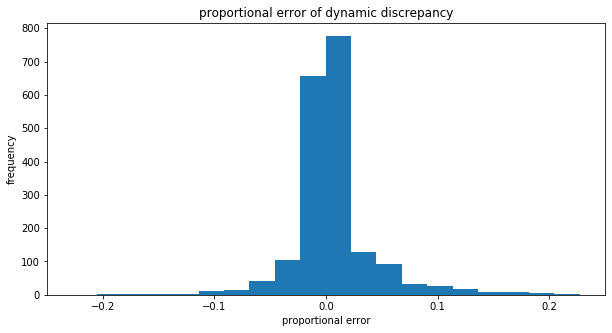

In [63]:
plt.hist(epsilon, bins=100)
plt.xlim([-0.25, 0.25])
plt.xlabel("proportional error")
plt.ylabel("frequency")
plt.title("proportional error of dynamic discrepancy")

In [64]:
ttestP = pd.Series(ttestP)
ttestP.index.name = "Jurisdiction"
ttestP.name = "p"

alpha = 0.05
significant = ttestP < alpha / ttestP.shape[0]
significant.name = "significant"

tTestResult = pd.concat([ttestP, significant], axis=1)
tTestResult

p  significant
Jurisdiction                         
Alabama         0.021460        False
Alaska          0.312993        False
Arizona         0.019251        False
Arkansas        0.122745        False
California      0.000113         True
Colorado        0.701105        False
Connecticut     0.078748        False
Delaware        0.000105         True
Florida         0.522616        False
Georgia         0.000652         True
Hawaii          0.012136        False
Idaho           0.282483        False
Illinois        0.204912        False
Indiana         0.316540        False
Iowa            0.000164         True
Kansas          0.302884        False
Kentucky        0.376608        False
Louisiana       0.145623        False
Maine           0.026839        False
Maryland        0.705949        False
Massachusetts   0.131804        False
Michigan        0.000058         True
Minnesota       0.001992        False
Mississippi     0.504642        False
Missouri        0.967690        False
Montana         0.278142        False
Nebraska        0.940091        False
Nevada          0.612446        False
New Hampshire   0.097608        False
New Jersey      0.382104        False
New Mexico      0.350952        False
New York        0.055133        False
North Carolina  0.360781        False
North Dakota    0.764647        False
Ohio            0.360959        False
Oklahoma        0.850099        False
Oregon          0.068128        False
Pennsylvania    0.295654        False
Rhode Island    0.553831        False
South Carolina  0.985559        False
South Dakota    0.049741        False
Tennessee       0.007703        False
Texas           0.206919        False
Utah            0.896208        False
Vermont         0.005942        False
Virginia        0.021252        False
Washington      0.920389        False
West Virginia   0.987941        False
Wisconsin       0.259233        False
Wyoming         0.268818        False
Federal         0.002246        False

The histogram shows $\epsilon$ is very likely to be centered at 0. A t-test with the null hypothesis that for each state $E[\epsilon] = 0$ suggests for most states, the null hypothesis should not be rejected. (Note: due to multiple test are being run, the significance level was adjusted.)

Thus, if a model is to be built to delineate the temporal dynamics of population, admission and release.
$$p[t] - p[t-1] = a[t] - r[t] + \epsilon p[t-1], E[\epsilon] = 0$$ will be a good choice.